In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
import numpy as np

with open("/content/gdrive/MyDrive/new_csv/birds.csv") as file_name:
    birds = np.loadtxt(file_name, delimiter=",")

with open("/content/gdrive/MyDrive/new_csv/mammals.csv") as file_name:
    mammals = np.loadtxt(file_name, delimiter=",")

birdsT= np.transpose(birds)
a1 = birdsT.reshape(160, 13, 32, order='C')

mammalsT= np.transpose(mammals)
a2 = mammalsT.reshape(200, 13, 32, order='C')

birds = a1
mammals = a2

y_mammals = [ [1] * 1 for _ in range(200)]
y_mammals = np.array(y_mammals)

y_birds = [ [0] * 1 for _ in range(160)]
y_birds = np.array(y_birds)


# concatenate 2 numpy arrays: row-wise
animals = np.concatenate((birds, mammals))

y_animals = np.concatenate((y_birds, y_mammals))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 11, 32)            3104      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 6, 32)            128       
 hNormalization)                                                 
                                                                 
 conv1d_9 (Conv1D)           (None, 4, 64)             6208      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                      

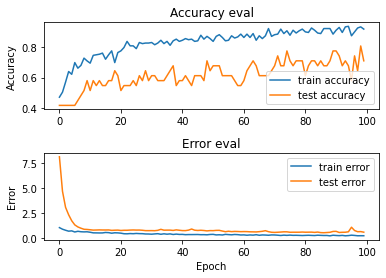

2/2 - 0s - loss: 0.3203 - accuracy: 0.7963 - 21ms/epoch - 11ms/step

Test accuracy: 0.7962962985038757


In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras.utils import np_utils

def load_data():

    X = animals
    y = y_animals
    return X, y

def plot_history(history):
    
    fig, axs = plt.subplots(2)
    fig.subplots_adjust(hspace=.5)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    print('')
    print('')
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def prepare_datasets(test_size, validation_size):

    # load data
    X, y = load_data()

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    #one-hot encoding
    y_train = np_utils.to_categorical(y_train)
    y_validation = np_utils.to_categorical(y_validation) 
    y_test = np_utils.to_categorical(y_test)
    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_validation = X_validation.astype('float32')
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    

    # build network topology
    model = keras.Sequential()

    # 1st layer
    model.add(keras.layers.Conv1D(32, (3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling1D((3), strides=(2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd layer
    model.add(keras.layers.Conv1D(64, (3), activation='relu'))
    model.add(keras.layers.MaxPooling1D((3), strides=(2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd layer
    #model.add(keras.layers.Conv1D(64, (2), activation='relu'))
    #model.add(keras.layers.MaxPooling1D((2), strides=(2), padding='same'))
    #model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu')) #changed to sigmoid from relu
    model.add(keras.layers.Dropout(0.2))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model



if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.15, 0.1)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)

    # compile model
    '''
    opt = keras.optimizers.SGD(learning_rate=0.01)
    model.compile(loss = "categorical_crossentropy", optimizer = opt)
    
    '''
    
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=16, epochs=100)
   
    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

